<h1 align=center>Individual Project</h1>
<h2 align=center> Myriam Ouanounou </h2>
Data on French vaccination campain - plot as heatmaps on French geographic regions

In [1]:
import pandas as pd
from pandas import Series, DataFrame, read_html
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

In [2]:
## you can change the data path for all the rest of the notebook here
dataPath=''

# 1. Data

## 1.1 Number of vaccinations per region and age

In [3]:
#reading CSV file downloaded from data.gouv.fr
data=pd.read_csv(dataPath+'vacsi-tot-a-reg-2021-02-22-20h15.csv', sep=',')
data

,reg,clage_vacsi,jour,n_tot_dose1,n_tot_dose2,couv_tot_dose1,couv_tot_dose2
0,1,24,2021-02-21,1,0,0.0,0.0
1,1,29,2021-02-21,15,2,0.1,0.0
2,1,39,2021-02-21,57,11,0.2,0.0
3,1,49,2021-02-21,86,10,0.2,0.0
4,1,59,2021-02-21,346,116,0.6,0.2
...,...,...,...,...,...,...,...
193,75,0,2021-02-21,280144,127425,4.7,2.1
194,76,0,2021-02-21,261309,116248,4.4,2.0
195,84,0,2021-02-21,301180,120478,3.7,1.5
196,93,0,2021-02-21,207951,91039,4.1,1.8


## 1.2 Region codes, and merge data

In [4]:
#adding regions information to database from INSEE 
regions=pd.read_csv(dataPath+"region2020.csv", sep=",")

data=pd.merge(data,regions)
data

,reg,clage_vacsi,jour,n_tot_dose1,n_tot_dose2,couv_tot_dose1,couv_tot_dose2,cheflieu,tncc,ncc,nccenr,libelle
0,1,24,2021-02-21,1,0,0.0,0.0,97105,3,GUADELOUPE,Guadeloupe,Guadeloupe
1,1,29,2021-02-21,15,2,0.1,0.0,97105,3,GUADELOUPE,Guadeloupe,Guadeloupe
2,1,39,2021-02-21,57,11,0.2,0.0,97105,3,GUADELOUPE,Guadeloupe,Guadeloupe
3,1,49,2021-02-21,86,10,0.2,0.0,97105,3,GUADELOUPE,Guadeloupe,Guadeloupe
4,1,59,2021-02-21,346,116,0.6,0.2,97105,3,GUADELOUPE,Guadeloupe,Guadeloupe
...,...,...,...,...,...,...,...,...,...,...,...,...
193,94,69,2021-02-21,1003,420,4.4,1.9,2A004,0,CORSE,Corse,Corse
194,94,74,2021-02-21,1412,464,6.9,2.3,2A004,0,CORSE,Corse,Corse
195,94,79,2021-02-21,4773,1321,29.6,8.2,2A004,0,CORSE,Corse,Corse
196,94,80,2021-02-21,8590,2625,35.5,10.9,2A004,0,CORSE,Corse,Corse


## 1.3 Data preparation

### 1.3.1 Lightening dataset

In [5]:
#lightening dataset
del data['couv_tot_dose1']
del data['couv_tot_dose2']
del data['cheflieu']
del data['tncc']
del data['ncc']
del data['nccenr']
data=data.rename(columns={'libelle':'region'})
data

,reg,clage_vacsi,jour,n_tot_dose1,n_tot_dose2,region
0,1,24,2021-02-21,1,0,Guadeloupe
1,1,29,2021-02-21,15,2,Guadeloupe
2,1,39,2021-02-21,57,11,Guadeloupe
3,1,49,2021-02-21,86,10,Guadeloupe
4,1,59,2021-02-21,346,116,Guadeloupe
...,...,...,...,...,...,...
193,94,69,2021-02-21,1003,420,Corse
194,94,74,2021-02-21,1412,464,Corse
195,94,79,2021-02-21,4773,1321,Corse
196,94,80,2021-02-21,8590,2625,Corse


### 1.3.2. Compute vaccination data for underage population

In [6]:
#Age classes are defined as follows by data.gouv.fr
#0 : all ages
#9 : 0-9
#17 : 10-17
#24 : 18-24
#29 : 25-29
#39 : 30-39
#49 : 40-49
#59 : 50-59
#69 : 60-69
#74 : 70-74
#79 : 75-79
#80 : 80 et +

# when looking at the dataset, I was able to see that the values associated 
# to the age category #0 are slightly higher than the total of the other age categories

# I also realized that the data set does not have #9 and #17 categories

# I concluded that the values associated to the #9 and #17 categories can be found by 
#calculating the difference between the values for #0 and the total values for other categories

#Calculating the total values per region for all age categories except #0
majeurs_dose1 = data[data.clage_vacsi !=0].groupby('reg')['n_tot_dose1'].sum()
majeurs_dose2 = data[data.clage_vacsi !=0].groupby('reg')['n_tot_dose2'].sum()

#Creating a list of the different regions number
from collections import OrderedDict 
reg_list=data['reg'].to_list()
# Removing duplicates
reg_list = list(OrderedDict.fromkeys(reg_list)) 

#Creating a list holding the row numbers where age category #0 can be found 
mineurs_index = []
for reg in reg_list:
    mineurs_index.append(data.loc[data.reg==reg][data.clage_vacsi==0].index.to_list())
    
#Flattening the list
mineurs_index = [item for sublist in mineurs_index for item in sublist]

#Replacing the values associated to #0 in order to get the values associated to #9 and #17
for i in range(len(mineurs_index)):
    data.iat[mineurs_index[i],3] -= majeurs_dose1.to_list()[i]
    data.iat[mineurs_index[i],4] -= majeurs_dose2.to_list()[i]



<ipython-input-6-9205c03aa00b>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mineurs_index.append(data.loc[data.reg==reg][data.clage_vacsi==0].index.to_list())


### 1.3.3. Customize Age Classes

In [7]:
#Creating wider age categories to narrow it down to three categories

# creating a list of conditions
agecat1 = []
agecat2 = []
agecat3 = []

for i in range (len(data)):
    if data.clage_vacsi[i] in [0,24,29,39] :
        agecat1.append(True)
        agecat2.append(False)
        agecat3.append(False)
    elif data.clage_vacsi[i] in [49,59,69,74]:
        agecat1.append(False)
        agecat2.append(True)
        agecat3.append(False) 
    else:
        agecat1.append(False)
        agecat2.append(False)
        agecat3.append(True)
        
conditions = [agecat1, agecat2, agecat3]

# creating a list of the values we want to assign for each condition
values = ['0-39yo','40-74yo','plus75yo']

# creating a new column and using np.select to assign values to it by using our lists as arguments
data['age_class'] = np.select(conditions, values)

# display updated DataFrame
data

,reg,clage_vacsi,jour,n_tot_dose1,n_tot_dose2,region,age_class
0,1,24,2021-02-21,1,0,Guadeloupe,0-39yo
1,1,29,2021-02-21,15,2,Guadeloupe,0-39yo
2,1,39,2021-02-21,57,11,Guadeloupe,0-39yo
3,1,49,2021-02-21,86,10,Guadeloupe,40-74yo
4,1,59,2021-02-21,346,116,Guadeloupe,40-74yo
...,...,...,...,...,...,...,...
193,94,69,2021-02-21,1003,420,Corse,40-74yo
194,94,74,2021-02-21,1412,464,Corse,40-74yo
195,94,79,2021-02-21,4773,1321,Corse,plus75yo
196,94,80,2021-02-21,8590,2625,Corse,plus75yo


### 1.3.4. Group by region and age class

In [8]:
#grouping data by region and age_class
data=data.groupby(['region','age_class']).sum().reset_index()
del data['reg']
del data['clage_vacsi']
data

,region,age_class,n_tot_dose1,n_tot_dose2
0,Auvergne-Rhône-Alpes,0-39yo,18628,5771
1,Auvergne-Rhône-Alpes,40-74yo,79004,40616
2,Auvergne-Rhône-Alpes,plus75yo,203548,74091
3,Bourgogne-Franche-Comté,0-39yo,6305,3132
4,Bourgogne-Franche-Comté,40-74yo,35654,21876
5,Bourgogne-Franche-Comté,plus75yo,101751,45117
6,Bretagne,0-39yo,8302,2228
7,Bretagne,40-74yo,41334,21057
8,Bretagne,plus75yo,98573,38992
9,Centre-Val de Loire,0-39yo,5886,1902


## 1.4 Population per region and age class

In [9]:
#Reading population data from INSEE
file=dataPath+"estim-pop-nreg-sexe-gca-1975-2021.xls"
sheet="2021" #reading latest population information

xl=pd.ExcelFile(file)
pop=xl.parse(sheet)


pop=pop.drop([0,1,2,3,17,23,24,25,26],axis=0) #deleting first lines, metropole line and last lines
pop=pop.rename(columns={"Estimation de population au 1er janvier, par région, sexe et grande classe d'âge": 'region',
                        'Unnamed: 1': '0-19yo',
                       'Unnamed: 2': '20-39yo',
                       'Unnamed: 3': '40-59yo',
                       'Unnamed: 4': '60-74yo',
                       'Unnamed: 5': 'plus75yo'})

#deleting unnecessary data (gender, etc)
del pop['Unnamed: 6']
del pop['Unnamed: 7']
del pop['Unnamed: 8']
del pop['Unnamed: 9']
del pop['Unnamed: 10']
del pop['Unnamed: 11']
del pop['Unnamed: 12']
del pop['Unnamed: 13']
del pop['Unnamed: 14']
del pop['Unnamed: 15']
del pop['Unnamed: 16']
del pop['Unnamed: 17']
del pop['Unnamed: 18']

pop



,region,0-19yo,20-39yo,40-59yo,60-74yo,plus75yo
4,Auvergne-Rhône-Alpes,1954790,1911198,2089709,1356765,780136
5,Bourgogne-Franche-Comté,624964,589828,713693,546216,311504
6,Bretagne,773706,715578,872568,651317,358128
7,Centre-Val-de-Loire,597813,541260,658371,485364,279623
8,Corse,70877,76723,93815,66789,41069
9,Grand Est,1258497,1292184,1444359,1010215,519562
10,Hauts-de-France,1522692,1439513,1520387,1014239,480631
11,Île-de-France,3157907,3430231,3205207,1677507,855577
12,Normandie,777468,727658,838557,626514,335895
13,Nouvelle-Aquitaine,1294248,1277782,1565929,1201320,700488


### 1.4.1 Customize Age Classes

In [10]:
#Creating age categories in population data
under19_list = pop['0-19yo'].to_list()
under39_list = pop['20-39yo'].to_list()
under59_list = pop['40-59yo'].to_list()
under74_list = pop['60-74yo'].to_list()
plus75_list = pop['plus75yo'].to_list()

agecat1 = []
agecat2 = []
for i in range (len(pop)):
    agecat1.append(under19_list[i] + under39_list[i])
    agecat2.append(under59_list[i] + under74_list[i])
agecat3 = plus75_list

pop['0-39yo']=agecat1
pop['40-74yo']=agecat2
pop['plus75yo']=agecat3

del pop['0-19yo']
del pop['20-39yo']
del pop['40-59yo']
del pop['60-74yo']

pop

,region,plus75yo,0-39yo,40-74yo
4,Auvergne-Rhône-Alpes,780136,3865988,3446474
5,Bourgogne-Franche-Comté,311504,1214792,1259909
6,Bretagne,358128,1489284,1523885
7,Centre-Val-de-Loire,279623,1139073,1143735
8,Corse,41069,147600,160604
9,Grand Est,519562,2550681,2454574
10,Hauts-de-France,480631,2962205,2534626
11,Île-de-France,855577,6588138,4882714
12,Normandie,335895,1505126,1465071
13,Nouvelle-Aquitaine,700488,2572030,2767249


### 1.4.2 Format population data

In [11]:
#combining age categories into one column
pop=pd.melt(pop,id_vars="region", 
        var_name="age_class", 
        value_name="population")


pop=pop.sort_values(['region','age_class'])
pop

,region,age_class,population
18,Auvergne-Rhône-Alpes,0-39yo,3865988
36,Auvergne-Rhône-Alpes,40-74yo,3446474
0,Auvergne-Rhône-Alpes,plus75yo,780136
19,Bourgogne-Franche-Comté,0-39yo,1214792
37,Bourgogne-Franche-Comté,40-74yo,1259909
1,Bourgogne-Franche-Comté,plus75yo,311504
20,Bretagne,0-39yo,1489284
38,Bretagne,40-74yo,1523885
2,Bretagne,plus75yo,358128
21,Centre-Val-de-Loire,0-39yo,1139073


### 1.4.3 Complete dataset

In [12]:
#adding population data to dataset
pop_list=pop['population'].to_list()

data['population']=pop_list
data


,region,age_class,n_tot_dose1,n_tot_dose2,population
0,Auvergne-Rhône-Alpes,0-39yo,18628,5771,3865988
1,Auvergne-Rhône-Alpes,40-74yo,79004,40616,3446474
2,Auvergne-Rhône-Alpes,plus75yo,203548,74091,780136
3,Bourgogne-Franche-Comté,0-39yo,6305,3132,1214792
4,Bourgogne-Franche-Comté,40-74yo,35654,21876,1259909
5,Bourgogne-Franche-Comté,plus75yo,101751,45117,311504
6,Bretagne,0-39yo,8302,2228,1489284
7,Bretagne,40-74yo,41334,21057,1523885
8,Bretagne,plus75yo,98573,38992,358128
9,Centre-Val de Loire,0-39yo,5886,1902,1139073


## 1.5 Calculations

In [13]:
#Adding percentage of population who received 1 dosis or 2 doses

dose1_list=data['n_tot_dose1'].to_list()
dose2_list=data['n_tot_dose2'].to_list()
pop_list=data['population'].to_list()

dose1_prop = [100*i / j for i, j in zip(dose1_list, pop_list)]
dose2_prop = [100*i / j for i, j in zip(dose2_list, pop_list)]

data['dose1%']=dose1_prop
data['dose2%']=dose2_prop

data

,region,age_class,n_tot_dose1,n_tot_dose2,population,dose1%,dose2%
0,Auvergne-Rhône-Alpes,0-39yo,18628,5771,3865988,0.481843,0.149276
1,Auvergne-Rhône-Alpes,40-74yo,79004,40616,3446474,2.292314,1.178480
2,Auvergne-Rhône-Alpes,plus75yo,203548,74091,780136,26.091348,9.497190
3,Bourgogne-Franche-Comté,0-39yo,6305,3132,1214792,0.519019,0.257822
4,Bourgogne-Franche-Comté,40-74yo,35654,21876,1259909,2.829887,1.736316
5,Bourgogne-Franche-Comté,plus75yo,101751,45117,311504,32.664428,14.483602
6,Bretagne,0-39yo,8302,2228,1489284,0.557449,0.149602
7,Bretagne,40-74yo,41334,21057,1523885,2.712409,1.381797
8,Bretagne,plus75yo,98573,38992,358128,27.524516,10.887727
9,Centre-Val de Loire,0-39yo,5886,1902,1139073,0.516736,0.166978


In [14]:
#keeping final data
del data['population']
data

,region,age_class,n_tot_dose1,n_tot_dose2,dose1%,dose2%
0,Auvergne-Rhône-Alpes,0-39yo,18628,5771,0.481843,0.149276
1,Auvergne-Rhône-Alpes,40-74yo,79004,40616,2.292314,1.178480
2,Auvergne-Rhône-Alpes,plus75yo,203548,74091,26.091348,9.497190
3,Bourgogne-Franche-Comté,0-39yo,6305,3132,0.519019,0.257822
4,Bourgogne-Franche-Comté,40-74yo,35654,21876,2.829887,1.736316
5,Bourgogne-Franche-Comté,plus75yo,101751,45117,32.664428,14.483602
6,Bretagne,0-39yo,8302,2228,0.557449,0.149602
7,Bretagne,40-74yo,41334,21057,2.712409,1.381797
8,Bretagne,plus75yo,98573,38992,27.524516,10.887727
9,Centre-Val de Loire,0-39yo,5886,1902,0.516736,0.166978


# 2. Mapping

Towards Data Science web site : <a href='https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac'>link </a>

## 2.1 shp Shape File of French regions

Downloaded from : url ='https://www.data.gouv.fr/fr/datasets/r/aacf9338-8944-4513-a7b9-4cd7c2db2fa9'
<p>URL obtained on governmental website</p>
https://www.data.gouv.fr/fr/datasets/contours-des-regions-francaises-sur-openstreetmap/


In [15]:
import geopandas as gpd

In [16]:
map_df = gpd.read_file(dataPath+"regions-20180101-shp/regions-20180101.shp")
map_df=map_df.rename(columns={'nom':'region'})
map_df.head()

,code_insee,region,nuts2,wikipedia,surf_km2,geometry
0,04,La Réunion,FR94,fr:La Réunion,2505.0,"MULTIPOLYGON (((55.21643 -21.03904, 55.21652 -..."
1,94,Corse,FR83,fr:Corse,8722.0,"MULTIPOLYGON (((8.53996 42.23689, 8.54030 42.2..."
2,02,Martinique,FR92,fr:Martinique,1089.0,"MULTIPOLYGON (((-61.22908 14.82247, -61.22895 ..."
3,11,Île-de-France,FR10,fr:Île-de-France,12069.0,"POLYGON ((1.44624 49.04639, 1.44945 49.04765, ..."
4,32,Hauts-de-France,FR22,fr:Nord-Pas-de-Calais-Picardie,31935.0,"MULTIPOLYGON (((1.37983 50.06518, 1.38000 50.0..."


In [17]:
# joining the geodataframe with the cleaned up csv dataframe
merged1 = map_df.set_index('region').join(data[data['age_class']=='0-39yo'].set_index('region'))
merged2 = map_df.set_index('region').join(data[data['age_class']=='40-74yo'].set_index('region'))
merged3 = map_df.set_index('region').join(data[data['age_class']=='plus75yo'].set_index('region'))

merged1.head()

,code_insee,nuts2,wikipedia,surf_km2,geometry,age_class,n_tot_dose1,n_tot_dose2,dose1%,dose2%
region,,,,,,,,,,
La Réunion,04,FR94,fr:La Réunion,2505.0,"MULTIPOLYGON (((55.21643 -21.03904, 55.21652 -...",0-39yo,863,163,0.189664,0.035823
Corse,94,FR83,fr:Corse,8722.0,"MULTIPOLYGON (((8.53996 42.23689, 8.54030 42.2...",0-39yo,473,218,0.320461,0.147696
Martinique,02,FR92,fr:Martinique,1089.0,"MULTIPOLYGON (((-61.22908 14.82247, -61.22895 ...",0-39yo,169,57,0.120086,0.040503
Île-de-France,11,FR10,fr:Île-de-France,12069.0,"POLYGON ((1.44624 49.04639, 1.44945 49.04765, ...",0-39yo,24397,10200,0.370317,0.154824
Hauts-de-France,32,FR22,fr:Nord-Pas-de-Calais-Picardie,31935.0,"MULTIPOLYGON (((1.37983 50.06518, 1.38000 50.0...",0-39yo,13755,5161,0.464350,0.174228


In [18]:
merged3

,code_insee,nuts2,wikipedia,surf_km2,geometry,age_class,n_tot_dose1,n_tot_dose2,dose1%,dose2%
region,,,,,,,,,,
La Réunion,04,FR94,fr:La Réunion,2505.0,"MULTIPOLYGON (((55.21643 -21.03904, 55.21652 -...",plus75yo,7850,985,17.143856,2.151172
Corse,94,FR83,fr:Corse,8722.0,"MULTIPOLYGON (((8.53996 42.23689, 8.54030 42.2...",plus75yo,14359,4475,34.963111,10.896296
Martinique,02,FR92,fr:Martinique,1089.0,"MULTIPOLYGON (((-61.22908 14.82247, -61.22895 ...",plus75yo,2076,747,5.387031,1.938397
Île-de-France,11,FR10,fr:Île-de-France,12069.0,"POLYGON ((1.44624 49.04639, 1.44945 49.04765, ...",plus75yo,226770,90339,26.504920,10.558839
Hauts-de-France,32,FR22,fr:Nord-Pas-de-Calais-Picardie,31935.0,"MULTIPOLYGON (((1.37983 50.06518, 1.38000 50.0...",plus75yo,105308,54285,21.910364,11.294527
Nouvelle-Aquitaine,75,FR61,fr:Nouvelle-Aquitaine,84747.0,"MULTIPOLYGON (((-1.79102 43.37292, -1.79048 43...",plus75yo,192125,78424,27.427308,11.195624
Normandie,28,FR25,fr:Région Normandie,30139.0,"MULTIPOLYGON (((-1.94877 49.71649, -1.94836 49...",plus75yo,95800,47272,28.520818,14.073446
Guadeloupe,01,FR91,fr:Guadeloupe,1634.0,"MULTIPOLYGON (((-61.80976 16.27270, -61.80976 ...",plus75yo,1099,195,3.063671,0.543599
Pays de la Loire,52,FR51,fr:Pays de la Loire,32430.0,"MULTIPOLYGON (((-2.55966 47.37430, -2.55941 47...",plus75yo,97215,45956,25.535587,12.071321


## 2.2 Map exploration : finding coordinates of each overseas region 

In [19]:
! pip install descartes 

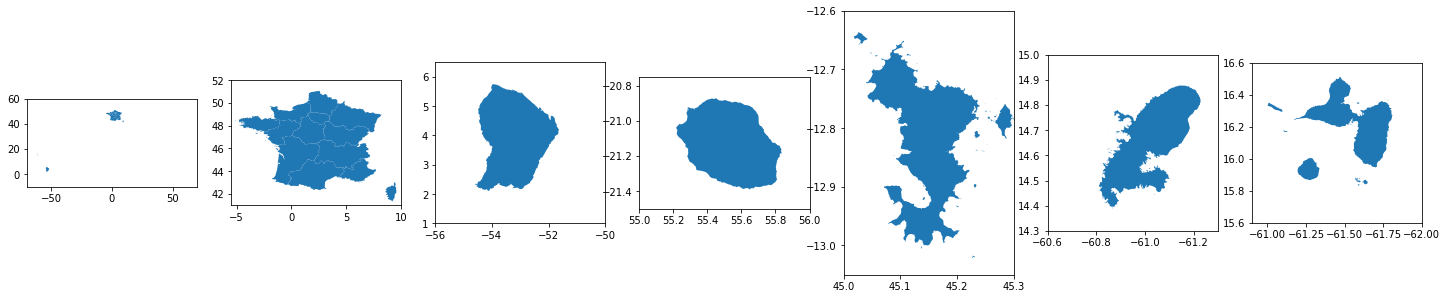

In [20]:
#MAP EXPLORATION

#Total 

fig, ax = plt.subplots(1,7, figsize=(25,10))

#grande carte
ax[0].set_xlim(-70,70)
ax[0].set_ylim(-10,60)

#métropole
ax[1].set_xlim(-5.5,10)
ax[1].set_ylim(41,52)

#Guyane
ax[2].set_xlim(-56,-50)
ax[2].set_ylim(1,6.5)

#La Réunion
ax[3].set_xlim(55,56)
ax[3].set_ylim(-21.5,-20.75)

#Mayotte
ax[4].set_xlim(45,45.3)
ax[4].set_ylim(-13.05,-12.6)

#Martinique
ax[5].set_xlim(-60.6,-61.3)
ax[5].set_ylim(14.3,15)

#Guadeloupe
ax[6].set_xlim(-60.9,-62)
ax[6].set_ylim(15.6,16.6)




map_df.plot(ax=ax[0])
map_df.plot(ax=ax[1])
map_df.plot(ax=ax[2])
map_df.plot(ax=ax[3])
map_df.plot(ax=ax[4])
map_df.plot(ax=ax[5])
map_df.plot(ax=ax[6])




## 2.3 Plotting geographic heatmap per class age and number of dosis received

In [21]:
# determining extreme values to build choropleth
top=[data['dose1%'].max(),data['dose2%'].max()]
top

[41.753171856978085, 14.483602136730186]

Heatmap scale x15 for 0-39 yo ; x5 for 40-74 yo


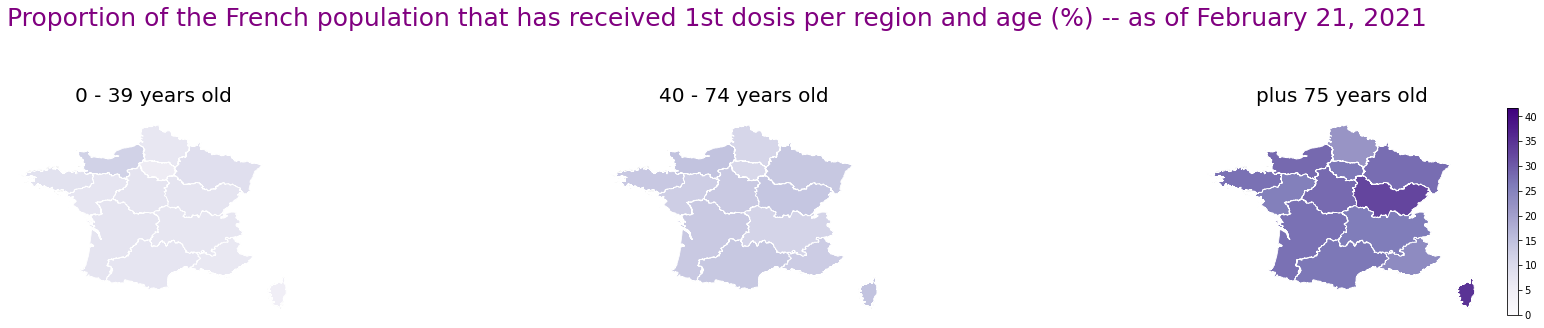

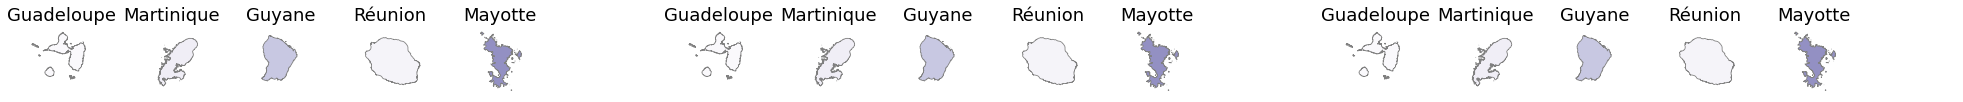

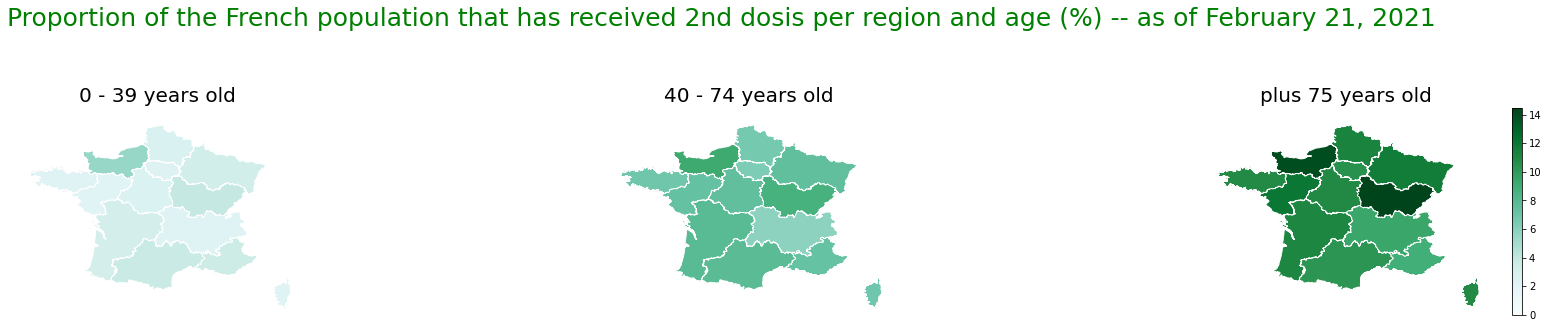

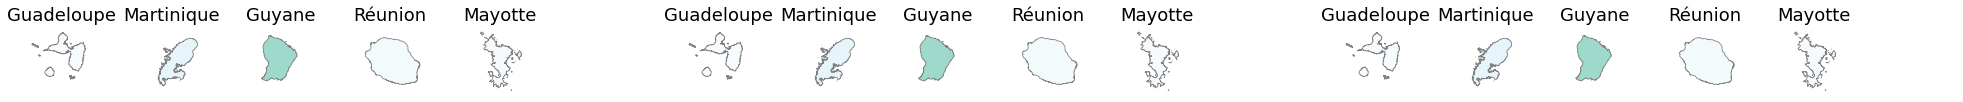

In [22]:
# set a variable that will call whatever column we want to visualise on the map
variable1 = 'dose1%'
variable2 = 'dose2%'

# create figure and axes for Matplotlib for Dosis 1
fig, ax = plt.subplots(1,3,figsize=(30, 5))

# set the range for the choropleth
vmin, vmax = 0, top[0]
sm = plt.cm.ScalarMappable(cmap='Purples', norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm)
fig.suptitle('Proportion of the French population that has received 1st dosis per region and age (%) -- as of February 21, 2021', fontsize=25 , color='Purple')

#plotting metropole for dosis 1
for i in range (3):
    ax[i].set_xlim(-5.5,10)
    ax[i].set_ylim(41,52)
    ax[i].set_axis_off()
ax[0].set_title('0 - 39 years old', fontdict={'fontsize': '20', 'fontweight' : '3'})
ax[1].set_title('40 - 74 years old', fontdict={'fontsize': '20', 'fontweight' : '3'})
ax[2].set_title('plus 75 years old', fontdict={'fontsize': '20', 'fontweight' : '3'})


    
merged1.plot(column=variable1, cmap='Purples', linewidth=0.8, ax=ax[0], edgecolor='1.0',norm=plt.Normalize(vmin=vmin, vmax=vmax/15))
merged2.plot(column=variable1, cmap='Purples', linewidth=0.8, ax=ax[1], edgecolor='1.0', norm=plt.Normalize(vmin=vmin, vmax=vmax/5))
merged3.plot(column=variable1, cmap='Purples', linewidth=0.8, ax=ax[2], edgecolor='1.0', norm=plt.Normalize(vmin=vmin, vmax=vmax))

plt.subplots_adjust(top=0.7)

#plotting overseas regions for dosis 1
fig, ax = plt.subplots(1,18,figsize=(35, 2))

for i in range(3):
    ax[6*i].set_xlim(-60.9,-62)
    ax[6*i].set_ylim(15.6,16.6)
    ax[6*i+1].set_xlim(-60.6,-61.3)
    ax[6*i+1].set_ylim(14.3,15)
    ax[6*i+2].set_xlim(-56,-50)
    ax[6*i+2].set_ylim(1,6.5)
    ax[6*i+3].set_xlim(55,56)
    ax[6*i+3].set_ylim(-21.5,-20.75)
    ax[6*i+4].set_xlim(45,45.3)
    ax[6*i+4].set_ylim(-13.05,-12.6)
    ax[6*i+5].set_xlim(10,12) # plotting empty space to create separation between age classes
    ax[6*i+5].set_ylim(10,12)
    
    ax[6*i].set_axis_off()
    ax[6*i+1].set_axis_off()
    ax[6*i+2].set_axis_off()
    ax[6*i+3].set_axis_off()
    ax[6*i+4].set_axis_off()
    ax[6*i+5].set_axis_off()

    ax[6*i].set_title('Guadeloupe', fontdict={'fontsize': '18', 'fontweight' : '3'})
    ax[6*i+1].set_title('Martinique', fontdict={'fontsize': '18', 'fontweight' : '3'})
    ax[6*i+2].set_title('Guyane', fontdict={'fontsize': '18', 'fontweight' : '3'})
    ax[6*i+3].set_title('Réunion', fontdict={'fontsize': '18', 'fontweight' : '3'})
    ax[6*i+4].set_title('Mayotte', fontdict={'fontsize': '18', 'fontweight' : '3'})

    
for i in range(6):
    merged1.plot(column=variable1, cmap='Purples', linewidth=0.8, ax=ax[3*i], edgecolor='0.5',norm=plt.Normalize(vmin=vmin, vmax=vmax/15))
    merged2.plot(column=variable1, cmap='Purples', linewidth=0.8, ax=ax[3*i+1], edgecolor='0.5', norm=plt.Normalize(vmin=vmin, vmax=vmax/5))
    merged3.plot(column=variable1, cmap='Purples', linewidth=0.8, ax=ax[3*i+2], edgecolor='0.5', norm=plt.Normalize(vmin=vmin, vmax=vmax))


plt.subplots_adjust(top=0.6)


# create figure and axes for Matplotlib for Dosis 2

fig, ax = plt.subplots(1,3,figsize=(30, 5))
# set the range for the choropleth
vmin, vmax = 0, top[1]
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm)
fig.suptitle('Proportion of the French population that has received 2nd dosis per region and age (%) -- as of February 21, 2021', fontsize=25 , color='Green')

print('Heatmap scale x15 for 0-39 yo ; x5 for 40-74 yo')

#plotting metropole for dosis 2
for i in range (3):
    ax[i].set_xlim(-5.5,10)
    ax[i].set_ylim(41,52)
    ax[i].set_axis_off()

ax[0].set_title('0 - 39 years old', fontdict={'fontsize': '20', 'fontweight' : '3'})
ax[1].set_title('40 - 74 years old', fontdict={'fontsize': '20', 'fontweight' : '3'})
ax[2].set_title('plus 75 years old', fontdict={'fontsize': '20', 'fontweight' : '3'})

    
merged1.plot(column=variable2, cmap='BuGn', linewidth=0.8, ax=ax[0], edgecolor='1.0',norm=plt.Normalize(vmin=vmin, vmax=vmax/15))
merged2.plot(column=variable2, cmap='BuGn', linewidth=0.8, ax=ax[1], edgecolor='1.0', norm=plt.Normalize(vmin=vmin, vmax=vmax/5))
merged3.plot(column=variable2, cmap='BuGn', linewidth=0.8, ax=ax[2], edgecolor='1.0', norm=plt.Normalize(vmin=vmin, vmax=vmax))

plt.subplots_adjust(top=0.7)

#plotting overseas regions for dosis 2
fig, ax = plt.subplots(1,18,figsize=(35, 2))

for i in range(3):
    ax[6*i].set_xlim(-60.9,-62)
    ax[6*i].set_ylim(15.6,16.6)
    ax[6*i+1].set_xlim(-60.6,-61.3)
    ax[6*i+1].set_ylim(14.3,15)
    ax[6*i+2].set_xlim(-56,-50)
    ax[6*i+2].set_ylim(1,6.5)
    ax[6*i+3].set_xlim(55,56)
    ax[6*i+3].set_ylim(-21.5,-20.75)
    ax[6*i+4].set_xlim(45,45.3)
    ax[6*i+4].set_ylim(-13.05,-12.6)
    ax[6*i+5].set_xlim(10,12) # plotting empty space to create separation between age classes
    ax[6*i+5].set_ylim(10,12)
    
    ax[6*i].set_axis_off()
    ax[6*i+1].set_axis_off()
    ax[6*i+2].set_axis_off()
    ax[6*i+3].set_axis_off()
    ax[6*i+4].set_axis_off()
    ax[6*i+5].set_axis_off()

    ax[6*i].set_title('Guadeloupe', fontdict={'fontsize': '18', 'fontweight' : '3'})
    ax[6*i+1].set_title('Martinique', fontdict={'fontsize': '18', 'fontweight' : '3'})
    ax[6*i+2].set_title('Guyane', fontdict={'fontsize': '18', 'fontweight' : '3'})
    ax[6*i+3].set_title('Réunion', fontdict={'fontsize': '18', 'fontweight' : '3'})
    ax[6*i+4].set_title('Mayotte', fontdict={'fontsize': '18', 'fontweight' : '3'})
    


for i in range(6):
    merged1.plot(column=variable2, cmap='BuGn', linewidth=0.8, ax=ax[3*i], edgecolor='0.5',norm=plt.Normalize(vmin=vmin, vmax=vmax/15))
    merged2.plot(column=variable2, cmap='BuGn', linewidth=0.8, ax=ax[3*i+1], edgecolor='0.5', norm=plt.Normalize(vmin=vmin, vmax=vmax/5))
    merged3.plot(column=variable2, cmap='BuGn', linewidth=0.8, ax=ax[3*i+2], edgecolor='0.5', norm=plt.Normalize(vmin=vmin, vmax=vmax))


plt.subplots_adjust(top=0.6)

In [23]:
# determining extreme values to build choropleth for absolute value (as opposed to the percentage presented above)
top=[data['n_tot_dose1'].max(),data['n_tot_dose2'].max()]
top

[226770, 90339]

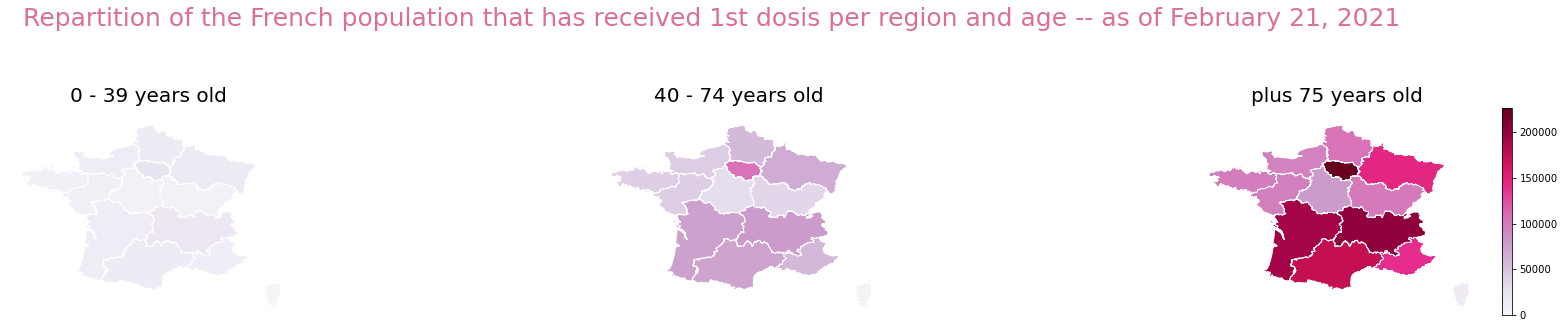

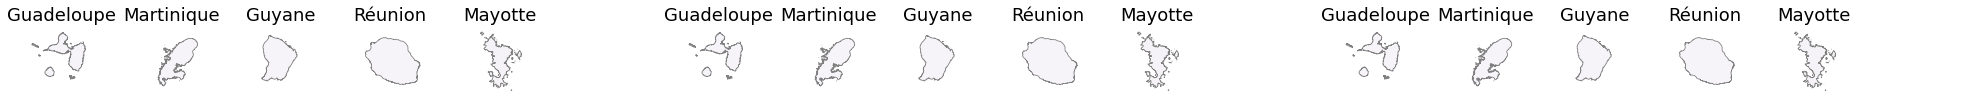

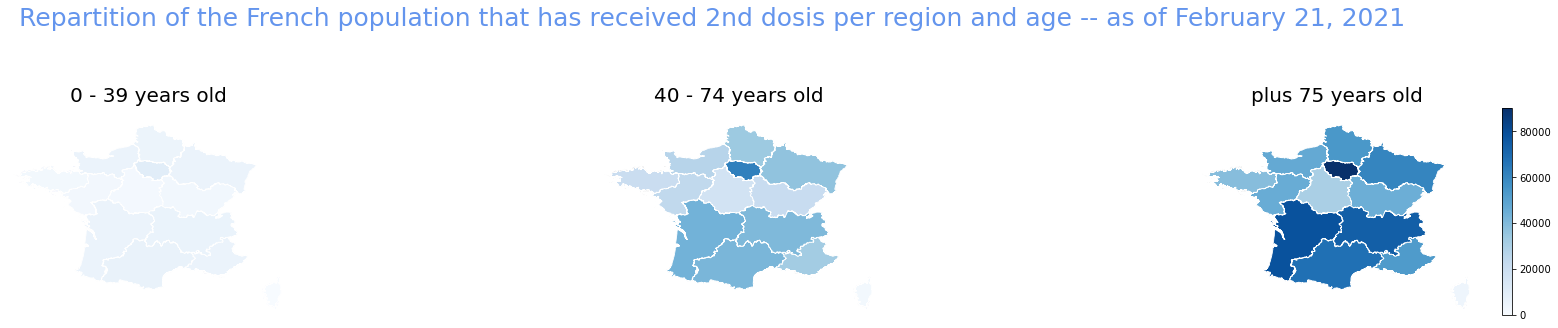

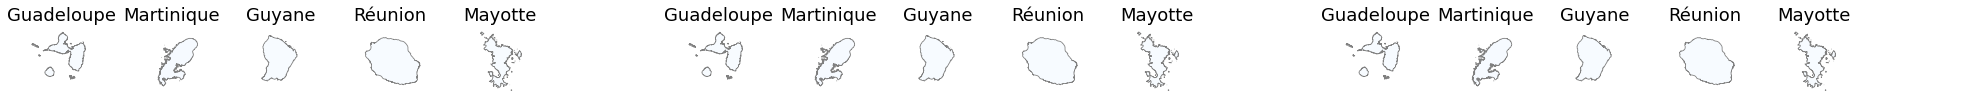

In [24]:
####### SAME CODE with few modifications (title, variables, colours) ########

# set a variable that will call whatever column we want to visualise on the map
variable1 = 'n_tot_dose1'
variable2 = 'n_tot_dose2'

# create figure and axes for Matplotlib for Dosis 1
fig, ax = plt.subplots(1,3,figsize=(30, 5))

# set the range for the choropleth
vmin, vmax = 0, top[0]
sm = plt.cm.ScalarMappable(cmap='PuRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm)
fig.suptitle('Repartition of the French population that has received 1st dosis per region and age -- as of February 21, 2021', fontsize=25 , color='palevioletred')

#plotting metropole for dosis 1
for i in range (3):
    ax[i].set_xlim(-5.5,10)
    ax[i].set_ylim(41,52)
    ax[i].set_axis_off()
ax[0].set_title('0 - 39 years old', fontdict={'fontsize': '20', 'fontweight' : '3'})
ax[1].set_title('40 - 74 years old', fontdict={'fontsize': '20', 'fontweight' : '3'})
ax[2].set_title('plus 75 years old', fontdict={'fontsize': '20', 'fontweight' : '3'})


    
merged1.plot(column=variable1, cmap='PuRd', linewidth=0.8, ax=ax[0], edgecolor='1.0',norm=plt.Normalize(vmin=vmin, vmax=vmax))
merged2.plot(column=variable1, cmap='PuRd', linewidth=0.8, ax=ax[1], edgecolor='1.0', norm=plt.Normalize(vmin=vmin, vmax=vmax))
merged3.plot(column=variable1, cmap='PuRd', linewidth=0.8, ax=ax[2], edgecolor='1.0', norm=plt.Normalize(vmin=vmin, vmax=vmax))

plt.subplots_adjust(top=0.7)

#plotting overseas regions for dosis 1
fig, ax = plt.subplots(1,18,figsize=(35, 2))

for i in range(3):
    ax[6*i].set_xlim(-60.9,-62)
    ax[6*i].set_ylim(15.6,16.6)
    ax[6*i+1].set_xlim(-60.6,-61.3)
    ax[6*i+1].set_ylim(14.3,15)
    ax[6*i+2].set_xlim(-56,-50)
    ax[6*i+2].set_ylim(1,6.5)
    ax[6*i+3].set_xlim(55,56)
    ax[6*i+3].set_ylim(-21.5,-20.75)
    ax[6*i+4].set_xlim(45,45.3)
    ax[6*i+4].set_ylim(-13.05,-12.6)
    ax[6*i+5].set_xlim(10,12) # plotting empty space to create separation between age classes
    ax[6*i+5].set_ylim(10,12)
    
    ax[6*i].set_axis_off()
    ax[6*i+1].set_axis_off()
    ax[6*i+2].set_axis_off()
    ax[6*i+3].set_axis_off()
    ax[6*i+4].set_axis_off()
    ax[6*i+5].set_axis_off()

    ax[6*i].set_title('Guadeloupe', fontdict={'fontsize': '18', 'fontweight' : '3'})
    ax[6*i+1].set_title('Martinique', fontdict={'fontsize': '18', 'fontweight' : '3'})
    ax[6*i+2].set_title('Guyane', fontdict={'fontsize': '18', 'fontweight' : '3'})
    ax[6*i+3].set_title('Réunion', fontdict={'fontsize': '18', 'fontweight' : '3'})
    ax[6*i+4].set_title('Mayotte', fontdict={'fontsize': '18', 'fontweight' : '3'})

    
for i in range(6):
    merged1.plot(column=variable1, cmap='PuRd', linewidth=0.8, ax=ax[3*i], edgecolor='0.5',norm=plt.Normalize(vmin=vmin, vmax=vmax))
    merged2.plot(column=variable1, cmap='PuRd', linewidth=0.8, ax=ax[3*i+1], edgecolor='0.5', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    merged3.plot(column=variable1, cmap='PuRd', linewidth=0.8, ax=ax[3*i+2], edgecolor='0.5', norm=plt.Normalize(vmin=vmin, vmax=vmax))


plt.subplots_adjust(top=0.6)


# create figure and axes for Matplotlib for Dosis 2

fig, ax = plt.subplots(1,3,figsize=(30, 5))
# set the range for the choropleth
vmin, vmax = 0, top[1]
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm)
fig.suptitle('Repartition of the French population that has received 2nd dosis per region and age -- as of February 21, 2021', fontsize=25 , color='cornflowerblue')


#plotting metropole for dosis 2
for i in range (3):
    ax[i].set_xlim(-5.5,10)
    ax[i].set_ylim(41,52)
    ax[i].set_axis_off()

ax[0].set_title('0 - 39 years old', fontdict={'fontsize': '20', 'fontweight' : '3'})
ax[1].set_title('40 - 74 years old', fontdict={'fontsize': '20', 'fontweight' : '3'})
ax[2].set_title('plus 75 years old', fontdict={'fontsize': '20', 'fontweight' : '3'})


    
merged1.plot(column=variable2, cmap='Blues', linewidth=0.8, ax=ax[0], edgecolor='1.0',norm=plt.Normalize(vmin=vmin, vmax=vmax))
merged2.plot(column=variable2, cmap='Blues', linewidth=0.8, ax=ax[1], edgecolor='1.0', norm=plt.Normalize(vmin=vmin, vmax=vmax))
merged3.plot(column=variable2, cmap='Blues', linewidth=0.8, ax=ax[2], edgecolor='1.0', norm=plt.Normalize(vmin=vmin, vmax=vmax))

plt.subplots_adjust(top=0.7)

#plotting overseas regions for dosis 2
fig, ax = plt.subplots(1,18,figsize=(35, 2))

for i in range(3):
    ax[6*i].set_xlim(-60.9,-62)
    ax[6*i].set_ylim(15.6,16.6)
    ax[6*i+1].set_xlim(-60.6,-61.3)
    ax[6*i+1].set_ylim(14.3,15)
    ax[6*i+2].set_xlim(-56,-50)
    ax[6*i+2].set_ylim(1,6.5)
    ax[6*i+3].set_xlim(55,56)
    ax[6*i+3].set_ylim(-21.5,-20.75)
    ax[6*i+4].set_xlim(45,45.3)
    ax[6*i+4].set_ylim(-13.05,-12.6)
    ax[6*i+5].set_xlim(10,12) # plotting empty space to create separation between age classes
    ax[6*i+5].set_ylim(10,12)
    
    ax[6*i].set_axis_off()
    ax[6*i+1].set_axis_off()
    ax[6*i+2].set_axis_off()
    ax[6*i+3].set_axis_off()
    ax[6*i+4].set_axis_off()
    ax[6*i+5].set_axis_off()

    ax[6*i].set_title('Guadeloupe', fontdict={'fontsize': '18', 'fontweight' : '3'})
    ax[6*i+1].set_title('Martinique', fontdict={'fontsize': '18', 'fontweight' : '3'})
    ax[6*i+2].set_title('Guyane', fontdict={'fontsize': '18', 'fontweight' : '3'})
    ax[6*i+3].set_title('Réunion', fontdict={'fontsize': '18', 'fontweight' : '3'})
    ax[6*i+4].set_title('Mayotte', fontdict={'fontsize': '18', 'fontweight' : '3'})
    


for i in range(6):
    merged1.plot(column=variable2, cmap='Blues', linewidth=0.8, ax=ax[3*i], edgecolor='0.5',norm=plt.Normalize(vmin=vmin, vmax=vmax))
    merged2.plot(column=variable2, cmap='Blues', linewidth=0.8, ax=ax[3*i+1], edgecolor='0.5', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    merged3.plot(column=variable2, cmap='Blues', linewidth=0.8, ax=ax[3*i+2], edgecolor='0.5', norm=plt.Normalize(vmin=vmin, vmax=vmax))


plt.subplots_adjust(top=0.6)

In [25]:
data[data['region']=='Normandie'] #checking values accordingly to intensity of colour on the map
#this allowed to see that it was necessary to adjust the scale 
#for the first two age classes in the proportion (%) maps
#otherwise the map was completely pale

,region,age_class,n_tot_dose1,n_tot_dose2,dose1%,dose2%
36,Normandie,0-39yo,12068,5541,0.801793,0.368142
37,Normandie,40-74yo,42907,27157,2.928664,1.853630
38,Normandie,plus75yo,95800,47272,28.520818,14.073446
